# **TimeGan Based Simulator**
***

### Overview 

1. **Load Data**: Reads the consolidated sensor data from a CSV file.  
2. **Preprocess Data**: Handles missing values, normalizes data, and ensures consistent 30-second intervals.  
3. **Visualize Trends**: Plots time-series data for cooling, maxigauge, and temperature to identify patterns and anomalies.  
4. **Feature Extraction**: Computes statistical metrics (mean, std, min, max) and checks data stationarity using the ADF test.  
5. **Prepare Training Data**: Constructs time-series sequences with a chosen window size (e.g., 60 timestamps).  
6. **Build TimeGAN**: Implements an LSTM-based generator and an RNN-based discriminator to learn temporal dependencies.  
7. **Train Model**: Optimizes the TimeGAN framework using adversarial learning to generate realistic synthetic time-series data.  
8. **Evaluate Results**: Assesses the quality of generated sequences by comparing them with real sensor data using statistical and visual methods.  
9. **Generate Synthetic Data**: Uses the trained TimeGAN model to produce new sensor readings that maintain the original data's statistical properties.  
10. **Visualization**: Plots real vs. synthetic data to validate the effectiveness of the model.  
---

### Step 1: Import Required Libraries

In [2]:
# Install dependencies
%pip install numpy pandas matplotlib seaborn tensorflow scikit-learn statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Normalization
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

***
### Step 2: Load and Preprocess Data
- Loading the consolidated CSV file.
- Handling missing values.
- Normalizing the data for better model performance.

In [6]:
# Load the dataset
data = pd.read_csv("../databases/processed_data/cd230831.csv")

# Convert the datetime column to a proper datetime format if needed
data['datetime'] = pd.to_datetime(data['datetime'])


# Display the first few rows to inspect the structure
print("First few rows of the dataset:")
print(data.head())

First few rows of the dataset:
             datetime  cooling_channel0  cooling_channel1  cooling_channel10  \
0 2023-08-31 00:00:30         15.596670         15.558330          15.542780   
1 2023-08-31 00:01:00         15.594503         15.558330          15.538204   
2 2023-08-31 00:01:30         15.592003         15.558330          15.532924   
3 2023-08-31 00:02:00         15.590465         15.553758          15.537758   
4 2023-08-31 00:02:30         15.589075         15.548483          15.544148   

   cooling_channel11  maxigauge_channel1  maxigauge_channel2  \
0          15.555560                0.02            0.088700   
1          15.546651                0.02            0.088713   
2          15.536371                0.02            0.088762   
3          15.549443                0.02            0.088800   
4          15.566108                0.02            0.088800   

   maxigauge_channel3  maxigauge_channel4  maxigauge_channel5  \
0           -1.480000               15

In [7]:
# Initialize StandardScaler
scaler = StandardScaler()

# Apply Z-score normalization (excluding the datetime column)
scaled_data = scaler.fit_transform(data.iloc[:, 1:])

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])
scaled_df.insert(0, 'datetime', data['datetime'])  # Reinsert datetime column

# Display summary statistics after standardization
print("\nSummary Statistics after Standardization:")
print(scaled_df.describe())

# Save the preprocessed data for future use
# scaled_df.to_csv("../databases/processed_data/TimeGAN_data.csv", index=False)
print("\nData standardization completed successfully. Saved as 'TimeGAN_data.csv'.")


Summary Statistics after Standardization:
                            datetime  cooling_channel0  cooling_channel1  \
count                          69112      6.911200e+04      6.911200e+04   
mean   2023-09-11 23:58:15.000000256      9.211805e-16      1.394931e-15   
min              2023-08-31 00:00:30     -3.214294e+00     -3.056965e+00   
25%       2023-09-05 23:59:22.500000      2.029070e-02     -1.656629e-01   
50%              2023-09-11 23:58:15      3.129120e-01      1.632958e-01   
75%       2023-09-17 23:57:07.500000      4.129965e-01      5.470944e-01   
max              2023-09-23 23:56:00      1.231259e+00      2.625233e+00   
std                              NaN      1.000007e+00      1.000007e+00   

       cooling_channel10  cooling_channel11  maxigauge_channel1  \
count       6.911200e+04       6.911200e+04        6.910900e+04   
mean       -5.527083e-16      -2.789861e-15        5.963258e-18   
min        -3.228404e+00      -3.096646e+00       -1.827294e-02   
25% 

In [8]:
# scaled_df.head()

### Step 3: Data Visualization
- Plot time-series trends for cooling, maxigauge, and temperature sensors.
- Identify any existing patterns or outliers in the dataset.
- Check if the standardization process was correctly applied.

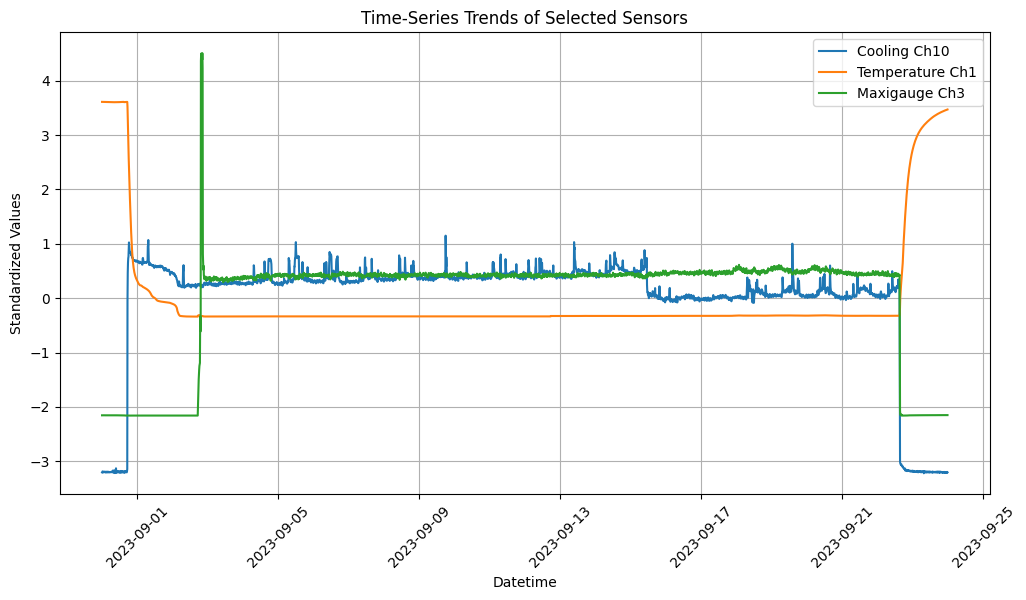

In [9]:
# Load the preprocessed dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select the chosen sensor channels
selected_columns = ['datetime', 'cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
subset_data = data[selected_columns]

# Downsample data (take one point every 10 minutes)
subset_downsampled = subset_data.iloc[::20, :]  # Select every 20th row (~10 min interval)

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the selected sensor data over time
sns.lineplot(x=subset_downsampled['datetime'], y=subset_downsampled['cooling_channel10'], label='Cooling Ch10')
sns.lineplot(x=subset_downsampled['datetime'], y=subset_downsampled['temperature_channel1'], label='Temperature Ch1')
sns.lineplot(x=subset_downsampled['datetime'], y=subset_downsampled['maxigauge_channel3'], label='Maxigauge Ch3')

# Formatting the plot
plt.xlabel("Datetime")
plt.ylabel("Standardized Values")
plt.title("Time-Series Trends of Selected Sensors")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Step 4: Feature Extraction
extract key statistical features from the dataset.

In [10]:
'''# Replace Inf values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values using forward-fill (or use mean imputation)
data.fillna(method='ffill', inplace=True)  # Forward-fill
data.fillna(method='bfill', inplace=True)  # Backward-fill (if needed)

# Drop any remaining NaN rows
data.dropna(inplace=True)

# Save the cleaned dataset (optional)
data.to_csv("../databases/processed_data/TimeGAN_data_cleaned.csv", index=False)

print("\n Data cleaned successfully. No NaN or Inf values remain.")'''

'# Replace Inf values with NaN\ndata.replace([np.inf, -np.inf], np.nan, inplace=True)\n\n# Fill NaN values using forward-fill (or use mean imputation)\ndata.fillna(method=\'ffill\', inplace=True)  # Forward-fill\ndata.fillna(method=\'bfill\', inplace=True)  # Backward-fill (if needed)\n\n# Drop any remaining NaN rows\ndata.dropna(inplace=True)\n\n# Save the cleaned dataset (optional)\ndata.to_csv("../databases/processed_data/TimeGAN_data_cleaned.csv", index=False)\n\nprint("\n Data cleaned successfully. No NaN or Inf values remain.")'

In [11]:
from statsmodels.tsa.stattools import adfuller

# Load the dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select only the relevant sensor columns
selected_columns = ['cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
sensor_data = data[selected_columns]

# Check for NaN and Inf values before ADF test
sensor_data.replace([np.inf, -np.inf], np.nan, inplace=True)
sensor_data.fillna(method='ffill', inplace=True)  # Forward-fill missing values
sensor_data.fillna(method='bfill', inplace=True)  # Backward-fill if needed
sensor_data.dropna(inplace=True)  # Drop any remaining NaN values

# Perform ADF test for selected sensors
adf_results = {}
for column in sensor_data.columns:
    adf_test = adfuller(sensor_data[column])
    adf_results[column] = {'ADF Statistic': adf_test[0], 'p-value': adf_test[1]}

# Convert ADF results to a DataFrame
adf_df = pd.DataFrame.from_dict(adf_results, orient='index')

# Display ADF test results
print("\nAugmented Dickey-Fuller (ADF) Test Results for Selected Sensors:")
print(adf_df)


/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_3086/1340927989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_3086/1340927989.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sensor_data.fillna(method='ffill', inplace=True)  # Forward-fill missing values
/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_3086/1340927989.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_da


Augmented Dickey-Fuller (ADF) Test Results for Selected Sensors:
                      ADF Statistic   p-value
cooling_channel10         -2.762297  0.063865
temperature_channel1      -2.635902  0.085802
maxigauge_channel3        -3.553566  0.006713


### Step 5: Prepare Training Data for TimeGAN
- Select 'cooling_channel10', 'temperature_channel1', and 'maxigauge_channel3' for training.
- Convert the dataset into sequences that TimeGAN can process.
- Define the time window (sequence length) for training.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Load dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select relevant sensor columns for training
selected_columns = ['cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
sensor_data = data[selected_columns].values  # Convert to numpy array

# 归一化到[-1, 1]范围
scaler = MinMaxScaler(feature_range=(-1, 1))
sensor_data_normalized = scaler.fit_transform(sensor_data)

# Define sequence length (e.g., 60 time steps = 30 minutes)
sequence_length = 120

# Function to create overlapping sequences for TimeGAN training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

# 创建训练序列
train_data = create_sequences(sensor_data_normalized, sequence_length)
# 80% 训练集，20% 测试集
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=False)

# 检查划分后的数据形状
print("\n✅ Training & Testing Data Split Completed!")
print(f"Training Data Shape: {train_data.shape}")  # 预期: (80% of total, 60, 3)
print(f"Testing Data Shape: {test_data.shape}")  # 预期: (20% of total, 60, 3)

# Check the shape of the prepared training data
print("\n✅ Training data prepared successfully!")
print(f"Training data shape: {train_data.shape}")  # Expected output: (num_samples, sequence_length, num_features)

# Define batch size and training epochs
batch_size = 32
epochs = 10


✅ Training & Testing Data Split Completed!
Training Data Shape: (55193, 120, 3)
Testing Data Shape: (13799, 120, 3)

✅ Training data prepared successfully!
Training data shape: (55193, 120, 3)


In [ ]:

# Load dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select relevant sensor columns for training
selected_columns = ['cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
sensor_data = data[selected_columns].values  # Convert to numpy array

# 归一化到[-1, 1]范围
scaler = MinMaxScaler(feature_range=(-1, 1))
sensor_data_normalized = scaler.fit_transform(sensor_data)

# Define sequence length (e.g., 60 time steps = 30 minutes)
sequence_length = 120

# Function to create overlapping sequences for TimeGAN training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

# 创建训练序列
train_data = create_sequences(sensor_data_normalized, sequence_length)
# 80% 训练集，20% 测试集
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=False)

# 检查划分后的数据形状
print("\n✅ Training & Testing Data Split Completed!")
print(f"Training Data Shape: {train_data.shape}")  # 预期: (80% of total, 60, 3)
print(f"Testing Data Shape: {test_data.shape}")  # 预期: (20% of total, 60, 3)

# Check the shape of the prepared training data
print("\n✅ Training data prepared successfully!")
print(f"Training data shape: {train_data.shape}")  # Expected output: (num_samples, sequence_length, num_features)

# Define batch size and training epochs
batch_size = 32
epochs = 10

In [13]:
# ================== 添加监督损失组件 ==================
class TimeGAN(Model):
    def __init__(self, generator, discriminator, supervisor, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.supervisor = supervisor
        
        # 定义独立的指标跟踪器
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.sup_loss_tracker = tf.keras.metrics.Mean(name="sup_loss")

    def compile(self, gen_optimizer, disc_optimizer, sup_optimizer, 
              gen_loss_fn, disc_loss_fn, sup_loss_fn):
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.sup_optimizer = sup_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.sup_loss_fn = sup_loss_fn

    def train_step(self, real_sequences):
        # 训练判别器
        with tf.GradientTape() as disc_tape:
            # 生成假数据
            fake_sequences = self.generator(real_sequences, training=True)
            
            # 获取判别结果
            real_output = self.discriminator(real_sequences, training=True)
            fake_output = self.discriminator(fake_sequences, training=True)
            
            # 计算判别器损失
            disc_loss_real = self.disc_loss_fn(tf.ones_like(real_output), real_output)
            disc_loss_fake = self.disc_loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss = (disc_loss_real + disc_loss_fake) / 2

        # 更新判别器
        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))

        # 训练生成器（含监督损失）
        with tf.GradientTape() as gen_tape, tf.GradientTape() as sup_tape:
            fake_sequences = self.generator(real_sequences, training=True)
            
            # 监督损失：预测下一个时间步
            pred_next_step = self.supervisor(fake_sequences[:, :-1, :])  # 使用前119步预测最后一步
            sup_loss = self.sup_loss_fn(fake_sequences[:, 1:, :], pred_next_step)
            
            # 对抗损失
            fake_output = self.discriminator(fake_sequences, training=False)
            gen_loss = self.gen_loss_fn(tf.ones_like(fake_output), fake_output)

            # 总损失组合
            total_gen_loss = gen_loss + 0.5 * sup_loss  # 权重可调

        # 更新生成器
        gen_grads = gen_tape.gradient(total_gen_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))
        
        # 更新监督器
        sup_grads = sup_tape.gradient(sup_loss, self.supervisor.trainable_weights)
        self.sup_optimizer.apply_gradients(zip(sup_grads, self.supervisor.trainable_weights))

        # 更新指标
        self.gen_loss_tracker.update_state(total_gen_loss)
        self.sup_loss_tracker.update_state(sup_loss)
        return {
            "gen_loss": self.gen_loss_tracker.result(),
            "sup_loss": self.sup_loss_tracker.result(),
        }

In [14]:
# 构建监督模型
def build_supervisor():
    inputs = Input(shape=(120, 3))
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(32, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(3))(x)  # 预测下一时间步
    return Model(inputs, outputs, name="Supervisor")

### Step 6: Implement TimeGAN (LSTM Generator + RNN Discriminator)
- LSTM-based Generator
- RNN-based Discriminator
- Embedding & Recovery Networks

In [15]:
'''
def build_generator():
    inputs = Input(shape=(120, 3))
    x = LSTM(24, return_sequences=True, kernel_initializer='orthogonal')(inputs)
    x = BatchNormalization()(x)  # 添加 Batch Normalization
    x = Dropout(0.2)(x)  # 轻微 Dropout 防止过拟合
    x = Dense(8, activation='tanh')(x)
    outputs = Dense(3, activation='tanh', kernel_initializer='glorot_normal')(x)
    return Model(inputs, outputs, name="Generator")'''

'\ndef build_generator():\n    inputs = Input(shape=(120, 3))\n    x = LSTM(24, return_sequences=True, kernel_initializer=\'orthogonal\')(inputs)\n    x = BatchNormalization()(x)  # 添加 Batch Normalization\n    x = Dropout(0.2)(x)  # 轻微 Dropout 防止过拟合\n    x = Dense(8, activation=\'tanh\')(x)\n    outputs = Dense(3, activation=\'tanh\', kernel_initializer=\'glorot_normal\')(x)\n    return Model(inputs, outputs, name="Generator")'

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Flatten, BatchNormalization, SimpleRNN

In [17]:
#RNN
def build_generator_rnn():
    inputs = Input(shape=(120, 3))
    
    # 替换 LSTM 为 RNN（保持结构一致）
    x = SimpleRNN(24, return_sequences=True, kernel_initializer='orthogonal')(inputs)
    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='tanh')(x)
    
    outputs = Dense(3, activation='tanh', kernel_initializer='glorot_normal')(x)
    
    return Model(inputs, outputs, name="Generator")


In [18]:
def build_discriminator():
    inputs = Input(shape=(120, 3))
    x = GRU(32, return_sequences=False, kernel_initializer='glorot_uniform')(inputs)
    x = BatchNormalization()(x)  # 归一化
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="Discriminator")


discriminator = build_discriminator()
print("\n✅ Discriminator Model Summary:")
discriminator.summary()


✅ Discriminator Model Summary:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,161 (16.25 KB)

 Non-trainable params: 64 (256.00 B)

In [19]:
'''# 定义优化器
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# 编译 Generator 和 Discriminator
generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)'''

"# 定义优化器\ngen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)\ndisc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)\n\n# 编译 Generator 和 Discriminator\ngenerator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)\ndiscriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)"

In [20]:

# ==================  异常注入函数 ==================
def inject_anomalies(synthetic_data, anomaly_ratio=0.05):
    """
    注入两种类型的异常：
    1. 突然尖峰（Spike）
    2. 持续偏移（Drift）
    """
    num_sequences, seq_len, num_features = synthetic_data.shape
    num_anomalies = int(num_sequences * anomaly_ratio)
    
    # 随机选择要注入异常的序列
    anomaly_indices = np.random.choice(num_sequences, num_anomalies, replace=False)
    
    for idx in anomaly_indices:
        # 随机选择异常类型
        if np.random.rand() > 0.5:
            # 类型1：突然尖峰（持续1-3个时间步）
            spike_length = np.random.randint(1, 4)
            spike_position = np.random.randint(0, seq_len - spike_length)
            feature_idx = np.random.randint(0, num_features)
            synthetic_data[idx, spike_position:spike_position+spike_length, feature_idx] *= 5
        else:
            # 类型2：持续偏移（持续10-30个时间步）
            drift_length = np.random.randint(10, 31)
            drift_position = np.random.randint(0, seq_len - drift_length)
            feature_idx = np.random.randint(0, num_features)
            drift_value = np.random.uniform(2.0, 4.0)  # 偏移幅度
            synthetic_data[idx, drift_position:drift_position+drift_length, feature_idx] *= drift_value
    
    return synthetic_data


In [21]:
'''# 增强数值稳定性
class TimeGAN(Model):
    def train_step(self, real_sequences):
        # 在生成器输出后添加数值截断
        fake_sequences = self.generator(real_sequences, training=True)
        fake_sequences = tf.clip_by_value(fake_sequences, -1.0 + 1e-6, 1.0 - 1e-6)  # 防止边界溢出

        # 在监督损失计算中添加 epsilon
        sup_loss = self.sup_loss_fn(
            real_sequences[:, 1:, :], 
            pred_next_step[:, :-1, :]
        ) + 1e-6  # 防止零梯度'''

'# 增强数值稳定性\nclass TimeGAN(Model):\n    def train_step(self, real_sequences):\n        # 在生成器输出后添加数值截断\n        fake_sequences = self.generator(real_sequences, training=True)\n        fake_sequences = tf.clip_by_value(fake_sequences, -1.0 + 1e-6, 1.0 - 1e-6)  # 防止边界溢出\n\n        # 在监督损失计算中添加 epsilon\n        sup_loss = self.sup_loss_fn(\n            real_sequences[:, 1:, :], \n            pred_next_step[:, :-1, :]\n        ) + 1e-6  # 防止零梯度'

In [22]:
import tensorflow as tf
# ================== 初始化所有组件 ==================
generator = build_generator_rnn()
discriminator = build_discriminator()
supervisor = build_supervisor()

# 编译TimeGAN
timegan = TimeGAN(
    generator=generator,
    discriminator=discriminator,
    supervisor=supervisor
)

# 定义损失函数和优化器
# 改用更稳定的损失函数组合
timegan.compile(
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6, clipnorm=0.1),
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6, clipnorm=0.1),  # 统一为clipnorm
    sup_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6, clipnorm=0.1),
    gen_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    disc_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    sup_loss_fn=tf.keras.losses.MeanAbsoluteError()  # 改用MAE更稳定
)
'''
# 将异常注入移至训练完成后（避免干扰梯度）
synthetic_data = generator.predict(seed_sequences)
synthetic_data_denorm = scaler.inverse_transform(synthetic_data.reshape(-1, 3)).reshape(synthetic_data.shape)
synthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm)  # 仅在最终生成数据后注入
'''
# print("\n✅ 生成数据形状:", synthetic_data_denorm.shape)  # (batch_size, 120, 3)
# print("✅ 包含异常的数据示例:")
# print(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看第0个序列的50-54时间步的第0个特征

'\n# 将异常注入移至训练完成后（避免干扰梯度）\nsynthetic_data = generator.predict(seed_sequences)\nsynthetic_data_denorm = scaler.inverse_transform(synthetic_data.reshape(-1, 3)).reshape(synthetic_data.shape)\nsynthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm)  # 仅在最终生成数据后注入\n'

### Step 7: Train TimeGAN (Small Training Setup)

In [23]:
'''import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense
from tqdm import tqdm  # 导入 tqdm 进度条

# 定义优化器
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)

# 准备标签
real_labels = np.ones((batch_size, 1), dtype=np.float32)
fake_labels = np.zeros((batch_size, 1), dtype=np.float32)

# 训练循环（增加 tqdm 进度条）
for epoch in range(1, epochs + 1):
    print(f"\n🚀 Epoch {epoch}/{epochs} 开始训练 ...")
    
    # 创建进度条
    progress_bar = tqdm(range(0, len(train_data) - batch_size, batch_size), desc=f"Epoch {epoch}")

    for i in progress_bar:
        real_sequences = train_data[i:i + batch_size]
        
        # 训练判别器
        with tf.GradientTape() as disc_tape:
            fake_sequences = generator(real_sequences, training=False)
            d_real = discriminator(real_sequences, training=True)
            d_fake = discriminator(fake_sequences, training=True)
            
            d_loss_real = tf.keras.losses.binary_crossentropy(real_labels, d_real)
            d_loss_fake = tf.keras.losses.binary_crossentropy(fake_labels, d_fake)
            d_loss_total = 0.5 * (tf.reduce_mean(d_loss_real) + tf.reduce_mean(d_loss_fake))
        
        disc_grads = disc_tape.gradient(d_loss_total, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
        
        # 训练生成器
        with tf.GradientTape() as gen_tape:
            fake_sequences = generator(real_sequences, training=True)
            d_fake = discriminator(fake_sequences, training=False)
            
            g_loss = tf.keras.losses.binary_crossentropy(real_labels, d_fake)
            g_loss = tf.reduce_mean(g_loss)
        
        gen_grads = gen_tape.gradient(g_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))

        # 更新进度条信息
        progress_bar.set_postfix({"D Loss": f"{d_loss_total.numpy():.4f}", "G Loss": f"{g_loss.numpy():.4f}"})

    print(f"✅ Epoch {epoch} 结束 - D Loss: {d_loss_total:.4f} | G Loss: {g_loss:.4f}")

print("\n🎉 训练完成！")'''

'import numpy as np\nimport pandas as pd\nimport tensorflow as tf\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Input, LSTM, GRU, Dense\nfrom tqdm import tqdm  # 导入 tqdm 进度条\n\n# 定义优化器\ngen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)\ndisc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)\n\n# 准备标签\nreal_labels = np.ones((batch_size, 1), dtype=np.float32)\nfake_labels = np.zeros((batch_size, 1), dtype=np.float32)\n\n# 训练循环（增加 tqdm 进度条）\nfor epoch in range(1, epochs + 1):\n    print(f"\n🚀 Epoch {epoch}/{epochs} 开始训练 ...")\n    \n    # 创建进度条\n    progress_bar = tqdm(range(0, len(train_data) - batch_size, batch_size), desc=f"Epoch {epoch}")\n\n    for i in progress_bar:\n        real_sequences = train_data[i:i + batch_size]\n        \n        # 训练判别器\n        with tf.GradientTape() as disc_tape:\n            fake_sequences = generator(real_sequences, training=False)\n            d_real = discriminator(re

In [24]:
from sklearn.preprocessing import MinMaxScaler

# 将数据 reshape 成适合 MinMaxScaler 的格式
train_data_reshaped = train_data.reshape(-1, 3)  # 展平成 (所有样本 * 时间步, 3)

# 归一化到 (-1, 1) 之间
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_reshaped = scaler.fit_transform(train_data_reshaped)

# 重新 reshape 回原始形状
train_data = train_data_reshaped.reshape(train_data.shape)


In [25]:
import numpy as np

for i in range(len(train_data)):
    if np.isnan(train_data[i]).any() or np.isinf(train_data[i]).any():
        print(f"⚠️ Warning: NaN or Inf detected in batch {i}")


⚠️ Warning: NaN or Inf detected in batch 1862
⚠️ Warning: NaN or Inf detected in batch 1863
⚠️ Warning: NaN or Inf detected in batch 1864
⚠️ Warning: NaN or Inf detected in batch 1865
⚠️ Warning: NaN or Inf detected in batch 1866
⚠️ Warning: NaN or Inf detected in batch 1867
⚠️ Warning: NaN or Inf detected in batch 1868
⚠️ Warning: NaN or Inf detected in batch 1869
⚠️ Warning: NaN or Inf detected in batch 1870
⚠️ Warning: NaN or Inf detected in batch 1871
⚠️ Warning: NaN or Inf detected in batch 1872
⚠️ Warning: NaN or Inf detected in batch 1873
⚠️ Warning: NaN or Inf detected in batch 1874
⚠️ Warning: NaN or Inf detected in batch 1875
⚠️ Warning: NaN or Inf detected in batch 1876
⚠️ Warning: NaN or Inf detected in batch 1877
⚠️ Warning: NaN or Inf detected in batch 1878
⚠️ Warning: NaN or Inf detected in batch 1879
⚠️ Warning: NaN or Inf detected in batch 1880
⚠️ Warning: NaN or Inf detected in batch 1881
⚠️ Warning: NaN or Inf detected in batch 1882
⚠️ Warning: NaN or Inf detected in

In [27]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# ================== 使用预定义的 TimeGAN 类 ==================
# 定义优化器参数（符合 TimeGAN 训练特点）
timegan.compile(
    gen_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    disc_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    sup_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    gen_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    disc_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    sup_loss_fn=tf.keras.losses.MeanSquaredError()
)

# ================== 改进训练流程 ==================
epochs = 1 # 改1
batch_size = 32
sequence_length = 120  # 每个时间序列的长度

# 处理数据批次，避免打乱时间顺序
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).shuffle(buffer_size=5, reshuffle_each_iteration=True)

# 训练循环
for epoch in range(1, epochs + 1):
    print(f"\n🚀 Epoch {epoch}/{epochs}")
    progress_bar = tqdm(train_dataset, desc="Training Progress")
    
    total_gen_loss = 0.0
    total_disc_loss = 0.0
    total_sup_loss = 0.0
    
    for batch in progress_bar:
        with tf.GradientTape() as gen_tape, tf.GradientTape() as sup_tape, tf.GradientTape() as disc_tape:
            # 生成假数据
            fake_sequences = timegan.generator(batch, training=True)

            # **修正 Supervisor 输入形状**
            fake_sequences_padded = tf.pad(fake_sequences[:, :-1, :], [[0, 0], [0, 1], [0, 0]], mode='CONSTANT')
            
            # 监督损失（预测未来时间步）
            pred_next_step = timegan.supervisor(fake_sequences_padded, training=True)  
            sup_loss = timegan.sup_loss_fn(fake_sequences[:, 1:, :], pred_next_step[:, :-1, :])

            # 判别器损失
            d_real = timegan.discriminator(batch, training=True)
            d_fake = timegan.discriminator(fake_sequences, training=True)

            real_labels = tf.ones_like(d_real)
            fake_labels = tf.zeros_like(d_fake)

            d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_real))
            d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, d_fake))
            d_loss_total = 0.5 * (d_loss_real + d_loss_fake)

            # 生成器损失
            g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_fake))

            # 总生成器损失（包含监督损失）
            total_gen_loss = g_loss + 0.5 * sup_loss

        # 计算梯度并更新判别器
        disc_grads = disc_tape.gradient(d_loss_total, timegan.discriminator.trainable_variables)
        timegan.disc_optimizer.apply_gradients(zip(disc_grads, timegan.discriminator.trainable_variables))

        # 计算梯度并更新生成器
        gen_grads = gen_tape.gradient(total_gen_loss, timegan.generator.trainable_variables)
        timegan.gen_optimizer.apply_gradients(zip(gen_grads, timegan.generator.trainable_variables))

        # 计算梯度并更新监督器
        sup_grads = sup_tape.gradient(sup_loss, timegan.supervisor.trainable_variables)
        timegan.sup_optimizer.apply_gradients(zip(sup_grads, timegan.supervisor.trainable_variables))

        # 记录损失
        total_gen_loss += total_gen_loss.numpy()
        total_sup_loss += sup_loss.numpy()
        total_disc_loss += d_loss_total.numpy()
        
        # 更新进度条
        progress_bar.set_postfix({
            "Gen Loss": f"{g_loss.numpy():.4f}",
            "Sup Loss": f"{sup_loss.numpy():.4f}",
            "Disc Loss": f"{d_loss_total.numpy():.4f}"
        })
    
    # 计算平均损失
    avg_gen_loss = total_gen_loss / len(train_dataset)
    avg_sup_loss = total_sup_loss / len(train_dataset)
    avg_disc_loss = total_disc_loss / len(train_dataset)

    print(f"✅ Epoch {epoch} 结束 - Gen Loss: {avg_gen_loss:.4f} | Sup Loss: {avg_sup_loss:.4f} | Disc Loss: {avg_disc_loss:.4f}")

print("\n🎉 训练完成！")



🚀 Epoch 1/1


Training Progress: 100%|██████████| 1724/1724 [25:02<00:00,  1.15it/s, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan]

✅ Epoch 1 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🎉 训练完成！


### step 8

In [ ]:
'''# ================== 生成数据并注入异常 ==================
# 生成数据时使用噪声，而非真实数据
noise = np.random.normal(size=(batch_size, sequence_length, 3))
synthetic_data = generator.predict(noise)

# 逆归一化并注入更平滑的异常
synthetic_data_denorm = scaler.inverse_transform(
    synthetic_data.reshape(-1, 3)
).reshape(synthetic_data.shape)

synthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm * np.random.uniform(0.9, 1.1))

print("\n生成数据示例（含异常）:")
print(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看异常数据'''

'# ================== 生成数据并注入异常 ==================\n# 生成数据时使用噪声，而非真实数据\nnoise = np.random.normal(size=(batch_size, sequence_length, 3))\nsynthetic_data = generator.predict(noise)\n\n# 逆归一化并注入更平滑的异常\nsynthetic_data_denorm = scaler.inverse_transform(\n    synthetic_data.reshape(-1, 3)\n).reshape(synthetic_data.shape)\n\nsynthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm * np.random.uniform(0.9, 1.1))\n\nprint("\n生成数据示例（含异常）:")\nprint(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看异常数据'

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# ================== 🚀 Step 1: 生成数据 ==================
# 生成数据时使用噪声，而非真实数据
batch_size = 32
sequence_length = 120  # 1小时数据
num_features = 3  # 3个传感器

# 生成噪声
noise = np.random.normal(size=(batch_size, sequence_length, num_features))
synthetic_data = generator.predict(noise)

# 逆归一化数据
synthetic_data_denorm = scaler.inverse_transform(
    synthetic_data.reshape(-1, num_features)
).reshape(synthetic_data.shape)

# 注入更平滑的异常
synthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm * np.random.uniform(0.9, 1.1))

print("\n✅ 生成数据示例（含异常）:")
print(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看异常数据



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

✅ 生成数据示例（含异常）:
[nan nan nan nan nan]


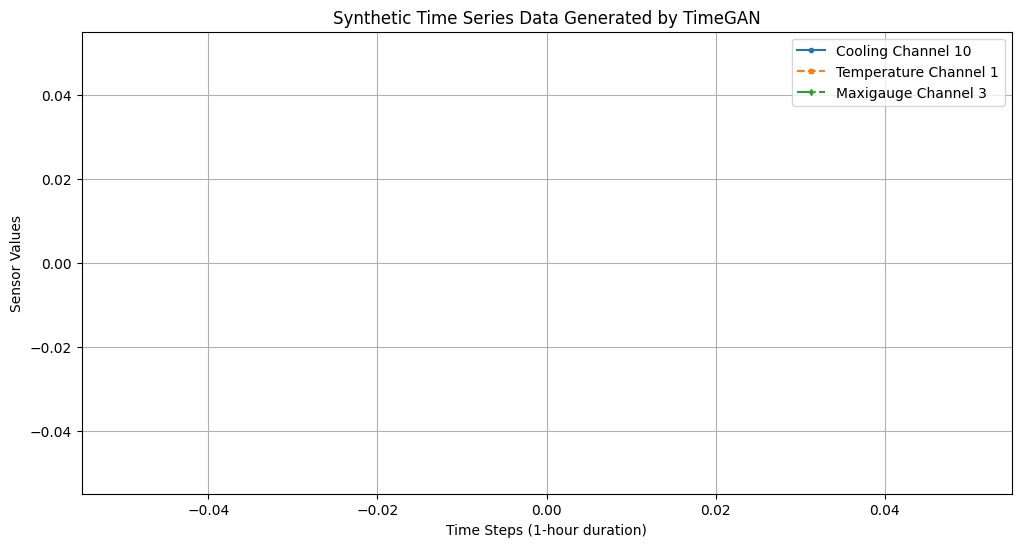


✅ 可视化图像已保存: ../databases/synthetic_time_series_rnn.png


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# ================== 🚀 Step 2: 可视化真实 vs 生成数据 ==================
# 选择一个样本进行可视化 (batch 中的第一个)
sample_idx = 0
sample_data = synthetic_data_with_anomalies[sample_idx]  # Shape: (120, 3)
time_steps = np.arange(sequence_length)  # 时间步

# 绘制 3 个特征的时间序列
plt.figure(figsize=(12, 6))
plt.plot(time_steps, sample_data[:, 0], label="Cooling Channel 10", linestyle='-', marker='o', markersize=3)
plt.plot(time_steps, sample_data[:, 1], label="Temperature Channel 1", linestyle='--', marker='s', markersize=3)
plt.plot(time_steps, sample_data[:, 2], label="Maxigauge Channel 3", linestyle='-.', marker='d', markersize=3)

# 图像美化
plt.xlabel("Time Steps (1-hour duration)")
plt.ylabel("Sensor Values")
plt.title("Synthetic Time Series Data Generated by TimeGAN")
plt.legend()
plt.grid(True)

# 保存可视化结果
plot_filename = "../databases/synthetic_time_series_rnn.png"
plt.savefig(plot_filename)
plt.show()

print(f"\n✅ 可视化图像已保存: {plot_filename}")

In [30]:
print(synthetic_data_with_anomalies)

[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 ...

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]]


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# ================== 🚀 Step 3: 保存生成数据到 CSV ==================
# 转换为 Pandas DataFrame
columns = ["Cooling Channel 10", "Temperature Channel 1", "Maxigauge Channel 3"]
simulated_df = pd.DataFrame(
    synthetic_data_with_anomalies.reshape(-1, num_features),
    columns=columns
)

# 保存 CSV 文件
csv_filename = "../databases/simulated_TimeGAN_rnn_output.csv"
simulated_df.to_csv(csv_filename, index=False)

print(f"\n✅ 生成数据已保存: {csv_filename}")


✅ 生成数据已保存: ../databases/simulated_TimeGAN_rnn_output.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


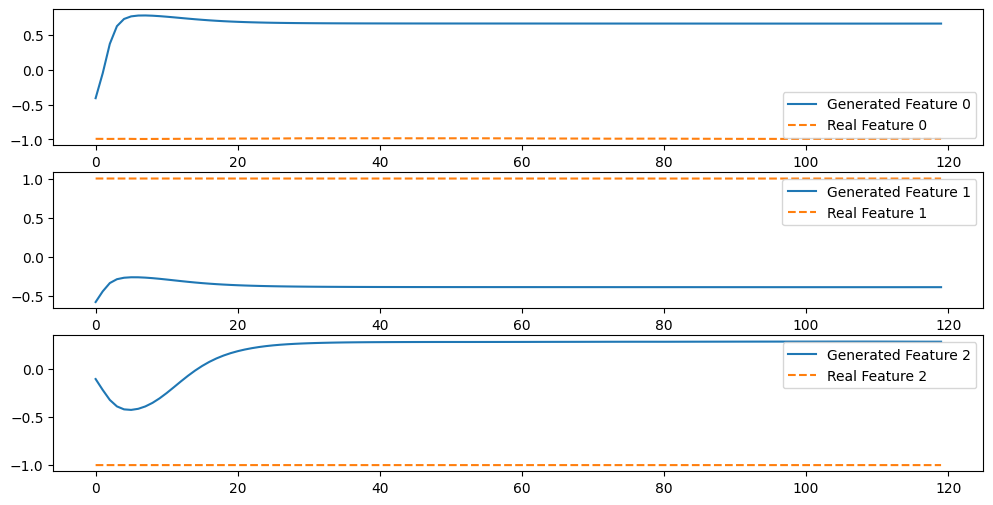

In [ ]:
import matplotlib.pyplot as plt

# 生成一些新数据
num_samples = 5  # 取5个样本
seed_sequences = train_data[:num_samples]  # 用真实数据的前几个序列作为 seed
generated_data = generator.predict(seed_sequences)

# 画图
plt.figure(figsize=(12, 6))
for i in range(3):  # 遍历3个传感器通道
    plt.subplot(3, 1, i+1)
    plt.plot(generated_data[0, :, i], label=f"Generated Feature {i}")
    plt.plot(seed_sequences[0, :, i], label=f"Real Feature {i}", linestyle='dashed')
    plt.legend()
plt.show()


In [ ]:
print("🚀 Checking train_data statistics:")
print(f"Min: {np.min(train_data)}, Max: {np.max(train_data)}")
print(f"Mean: {np.mean(train_data)}, Std: {np.std(train_data)}")


🚀 Checking train_data statistics:
Min: -1.0, Max: 1.0
Mean: -0.23709377864240339, Std: 0.6784140339499032


In [ ]:
import numpy as np

# 计算真实数据统计量
real_mean = np.mean(train_data, axis=(0,1))  # (num_features,)
real_std = np.std(train_data, axis=(0,1))

# 计算生成数据统计量
gen_mean = np.mean(generated_data, axis=(0,1))
gen_std = np.std(generated_data, axis=(0,1))

# 计算均值和标准差的相对误差
mean_diff = np.abs(real_mean - gen_mean) / real_mean
std_diff = np.abs(real_std - gen_std) / real_std

print("📊 生成数据 vs. 真实数据的误差:")
print(f"均值误差: {mean_diff}")
print(f"标准差误差: {std_diff}")


📊 生成数据 vs. 真实数据的误差:
均值误差: [ 0.21843643 -0.57950066 -1.56378022]
标准差误差: [0.59881909 0.90655159 0.30142067]


In [ ]:
'''import matplotlib.pyplot as plt

# 选择一个 batch 的第 1 组时间序列
real_sample = test_sequences[0]  # 真实数据
generated_sample = generated_sequences[0]  # 生成数据

plt.figure(figsize=(12, 6))

# 可视化 cooling_channel10
plt.subplot(3, 1, 1)
plt.plot(real_sample[:, 0], label="Real Cooling Channel", linestyle='dotted')
plt.plot(generated_sample[:, 0], label="Generated Cooling Channel")
plt.legend()

# 可视化 temperature_channel1
plt.subplot(3, 1, 2)
plt.plot(real_sample[:, 1], label="Real Temperature Channel", linestyle='dotted')
plt.plot(generated_sample[:, 1], label="Generated Temperature Channel")
plt.legend()

# 可视化 maxigauge_channel3
plt.subplot(3, 1, 3)
plt.plot(real_sample[:, 2], label="Real Maxigauge Channel", linestyle='dotted')
plt.plot(generated_sample[:, 2], label="Generated Maxigauge Channel")
plt.legend()

plt.tight_layout()
plt.show()
'''

'import matplotlib.pyplot as plt\n\n# 选择一个 batch 的第 1 组时间序列\nreal_sample = test_sequences[0]  # 真实数据\ngenerated_sample = generated_sequences[0]  # 生成数据\n\nplt.figure(figsize=(12, 6))\n\n# 可视化 cooling_channel10\nplt.subplot(3, 1, 1)\nplt.plot(real_sample[:, 0], label="Real Cooling Channel", linestyle=\'dotted\')\nplt.plot(generated_sample[:, 0], label="Generated Cooling Channel")\nplt.legend()\n\n# 可视化 temperature_channel1\nplt.subplot(3, 1, 2)\nplt.plot(real_sample[:, 1], label="Real Temperature Channel", linestyle=\'dotted\')\nplt.plot(generated_sample[:, 1], label="Generated Temperature Channel")\nplt.legend()\n\n# 可视化 maxigauge_channel3\nplt.subplot(3, 1, 3)\nplt.plot(real_sample[:, 2], label="Real Maxigauge Channel", linestyle=\'dotted\')\nplt.plot(generated_sample[:, 2], label="Generated Maxigauge Channel")\nplt.legend()\n\nplt.tight_layout()\nplt.show()\n'

### Model Build Snippet With Tuned Hyperparameters

In [178]:
# Step 1: 展平数据
train_data_reshaped = train_data.reshape(-1, 3)

# Step 2: 替换掉 NaN 和 Inf（可替换为均值，默认填 0）
for i in range(train_data_reshaped.shape[1]):
    col = train_data_reshaped[:, i]
    col_mean = np.nanmean(col[np.isfinite(col)])
    col[~np.isfinite(col)] = col_mean
    train_data_reshaped[:, i] = col

# Step 3: 执行 MinMaxScaler 归一化到 (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_reshaped = scaler.fit_transform(train_data_reshaped)

# Step 4: reshape 回原始形状
train_data = train_data_reshaped.reshape(train_data.shape)

# Step 5: 再次验证是否还有 NaN 或 Inf
for i in range(len(train_data)):
    if not np.all(np.isfinite(train_data[i])):
        print(f"⚠️ Still has NaN or Inf in batch {i}")

In [ ]:
# Generator
def build_generator_hyper():
    inputs = Input(shape=(120, 3))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='tanh')(x)
    outputs = Dense(3, activation='tanh')(x)
    return Model(inputs, outputs)
# Supervisor
def build_supervisor_hyper():
    inputs = Input(shape=(120, 3))
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(32, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(3))(x)
    return Model(inputs, outputs)

# Discriminator
def build_discriminator_hyper():
    inputs = Input(shape=(120, 3))
    x = GRU(64, return_sequences=False)(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

In [ ]:
# ================== 初始化所有组件 ==================
generator = build_generator_hyper()
discriminator = build_discriminator_hyper()
supervisor = build_supervisor_hyper()

# 编译TimeGAN
timegan = TimeGAN(
    generator=generator,
    discriminator=discriminator,
    supervisor=supervisor
)

In [70]:
import os

# ========== Compile TimeGAN ==========
timegan.compile(
    gen_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    disc_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    sup_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    gen_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    disc_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    sup_loss_fn=tf.keras.losses.MeanSquaredError()
)

# ========== Hyperparameters ==========
epochs = 10
batch_size = 32
sequence_length = 120

# ========== Create batched dataset ==========
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).shuffle(buffer_size=100, reshuffle_each_iteration=True)

# ========== Create directory to save models ==========
os.makedirs("saved_models", exist_ok=True)
best_total_loss = float('inf')

In [72]:
# ========== Training Loop ==========
for epoch in range(1, epochs + 1):
    print(f"\n🚀 Epoch {epoch}/{epochs}")
    progress_bar = tqdm(train_dataset, desc="Training Progress")

    total_gen_loss = 0.0
    total_sup_loss = 0.0
    total_disc_loss = 0.0
    num_batches = 0

    for batch in progress_bar:
        num_batches += 1

        with tf.GradientTape() as gen_tape, tf.GradientTape() as sup_tape, tf.GradientTape() as disc_tape:
            fake_sequences = timegan.generator(batch, training=True)

            padded_input = tf.pad(fake_sequences[:, :-1, :], [[0, 0], [0, 1], [0, 0]])
            pred_next_step = timegan.supervisor(padded_input, training=True)
            sup_loss = timegan.sup_loss_fn(fake_sequences[:, 1:, :], pred_next_step[:, :-1, :])

            d_real = timegan.discriminator(batch, training=True)
            d_fake = timegan.discriminator(fake_sequences, training=True)

            real_labels = tf.ones_like(d_real)
            fake_labels = tf.zeros_like(d_fake)

            d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_real))
            d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, d_fake))
            d_loss_total = 0.5 * (d_loss_real + d_loss_fake)

            g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_fake))
            combined_gen_loss = g_loss + 0.5 * sup_loss

        # Apply gradients
        disc_grads = disc_tape.gradient(d_loss_total, timegan.discriminator.trainable_variables)
        timegan.disc_optimizer.apply_gradients(zip(disc_grads, timegan.discriminator.trainable_variables))

        gen_grads = gen_tape.gradient(combined_gen_loss, timegan.generator.trainable_variables)
        timegan.gen_optimizer.apply_gradients(zip(gen_grads, timegan.generator.trainable_variables))

        sup_grads = sup_tape.gradient(sup_loss, timegan.supervisor.trainable_variables)
        timegan.sup_optimizer.apply_gradients(zip(sup_grads, timegan.supervisor.trainable_variables))

        # Accumulate loss
        total_gen_loss += g_loss.numpy()
        total_sup_loss += sup_loss.numpy()
        total_disc_loss += d_loss_total.numpy()

        progress_bar.set_postfix({
            "G Loss": f"{g_loss.numpy():.4f}",
            "Sup Loss": f"{sup_loss.numpy():.4f}",
            "D Loss": f"{d_loss_total.numpy():.4f}"
        })

    # Epoch loss summary
    avg_g_loss = total_gen_loss / num_batches
    avg_sup_loss = total_sup_loss / num_batches
    avg_d_loss = total_disc_loss / num_batches

    print(f"✅ Epoch {epoch} Summary - G Loss: {avg_g_loss:.4f} | Sup Loss: {avg_sup_loss:.4f} | D Loss: {avg_d_loss:.4f}")

    # Save best models
    current_total_loss = avg_g_loss + 0.5 * avg_sup_loss
    if current_total_loss < best_total_loss:
        best_total_loss = current_total_loss
        timegan.generator.save("saved_models/best_generator.h5")
        timegan.supervisor.save("saved_models/best_supervisor.h5")
        timegan.discriminator.save("saved_models/best_discriminator.h5")
        print("💾 Saved new best models!")

print("\n🎉 Training Complete!")


🚀 Epoch 1/10


Training Progress: 100%|██████████| 1724/1724 [27:40<00:00,  1.04it/s, G Loss=0.6869, Sup Loss=0.0050, D Loss=0.6999]


✅ Epoch 1 Summary - G Loss: 0.6754 | Sup Loss: 0.0116 | D Loss: 0.6833
💾 Saved new best models!

🚀 Epoch 2/10


Training Progress: 100%|██████████| 1724/1724 [28:07<00:00,  1.02it/s, G Loss=0.6957, Sup Loss=0.0027, D Loss=0.6938]


✅ Epoch 2 Summary - G Loss: 0.7066 | Sup Loss: 0.0076 | D Loss: 0.6861

🚀 Epoch 3/10


Training Progress: 100%|██████████| 1724/1724 [27:42<00:00,  1.04it/s, G Loss=0.6963, Sup Loss=0.0029, D Loss=0.6984]


✅ Epoch 3 Summary - G Loss: 0.6989 | Sup Loss: 0.0100 | D Loss: 0.6937

🚀 Epoch 4/10


Training Progress: 100%|██████████| 1724/1724 [27:36<00:00,  1.04it/s, G Loss=0.6813, Sup Loss=0.0114, D Loss=0.6676]


✅ Epoch 4 Summary - G Loss: 0.8475 | Sup Loss: 0.0107 | D Loss: 0.6775

🚀 Epoch 5/10


Training Progress: 100%|██████████| 1724/1724 [27:38<00:00,  1.04it/s, G Loss=0.6994, Sup Loss=0.0026, D Loss=0.6934]


✅ Epoch 5 Summary - G Loss: 0.7792 | Sup Loss: 0.0061 | D Loss: 0.6708

🚀 Epoch 6/10


Training Progress: 100%|██████████| 1724/1724 [27:40<00:00,  1.04it/s, G Loss=0.7049, Sup Loss=0.0021, D Loss=0.7007]


✅ Epoch 6 Summary - G Loss: 0.7021 | Sup Loss: 0.0064 | D Loss: 0.6765

🚀 Epoch 7/10


Training Progress: 100%|██████████| 1724/1724 [27:36<00:00,  1.04it/s, G Loss=0.7125, Sup Loss=0.0074, D Loss=0.6442]


✅ Epoch 7 Summary - G Loss: 0.7517 | Sup Loss: 0.0074 | D Loss: 0.6707

🚀 Epoch 8/10


Training Progress: 100%|██████████| 1724/1724 [27:47<00:00,  1.03it/s, G Loss=0.6799, Sup Loss=0.0038, D Loss=0.7004]


✅ Epoch 8 Summary - G Loss: 0.7997 | Sup Loss: 0.0089 | D Loss: 0.6931

🚀 Epoch 9/10


Training Progress: 100%|██████████| 1724/1724 [27:53<00:00,  1.03it/s, G Loss=0.9691, Sup Loss=0.0043, D Loss=0.5088]


✅ Epoch 9 Summary - G Loss: 0.8988 | Sup Loss: 0.0065 | D Loss: 0.6841

🚀 Epoch 10/10


Training Progress: 100%|██████████| 1724/1724 [27:30<00:00,  1.04it/s, G Loss=0.7199, Sup Loss=0.0192, D Loss=0.6682]

✅ Epoch 10 Summary - G Loss: 0.7519 | Sup Loss: 0.0122 | D Loss: 0.6879

🎉 Training Complete!


In [ ]:
# ================== Step 1: 生成数据 ==================
# 生成数据时使用噪声，而非真实数据
batch_size = 32
sequence_length = 120  # 1小时数据
num_features = 3  # 3个传感器

# 生成噪声
noise = np.random.normal(size=(batch_size, sequence_length, num_features))
synthetic_data = generator.predict(noise)

# 逆归一化数据
synthetic_data_denorm = scaler.inverse_transform(
    synthetic_data.reshape(-1, num_features)
).reshape(synthetic_data.shape)

# 注入更平滑的异常
synthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm * np.random.uniform(0.9, 1.1))

print("\n✅ 生成数据示例（含异常）:")
print(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看异常数据

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

✅ 生成数据示例（含异常）:
[-0.18451813 -0.19550449 -0.11306023 -0.02919536  0.07662386]


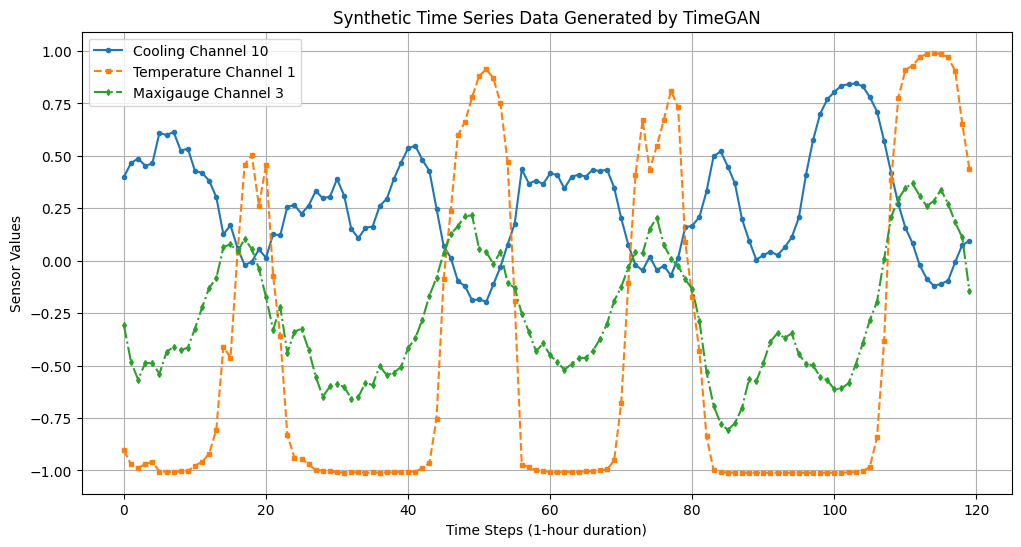


✅ 可视化图像已保存: ../databases/synthetic_time_series.png


In [ ]:
# ================== 🚀 Step 2: 可视化真实 vs 生成数据 ==================
# 选择一个样本进行可视化 (batch 中的第一个)
sample_idx = 0
sample_data = synthetic_data_with_anomalies[sample_idx]  # Shape: (120, 3)
time_steps = np.arange(sequence_length)  # 时间步

# 绘制 3 个特征的时间序列
plt.figure(figsize=(12, 6))
plt.plot(time_steps, sample_data[:, 0], label="Cooling Channel 10", linestyle='-', marker='o', markersize=3)
plt.plot(time_steps, sample_data[:, 1], label="Temperature Channel 1", linestyle='--', marker='s', markersize=3)
plt.plot(time_steps, sample_data[:, 2], label="Maxigauge Channel 3", linestyle='-.', marker='d', markersize=3)

# 图像美化
plt.xlabel("Time Steps (1-hour duration)")
plt.ylabel("Sensor Values")
plt.title("Synthetic Time Series Data Generated by TimeGAN")
plt.legend()
plt.grid(True)

# 保存可视化结果
plot_filename = "../databases/synthetic_time_series.png"
plt.savefig(plot_filename)
plt.show()

print(f"\n✅ 可视化图像已保存: {plot_filename}")

## Optimizing the hyperparameters in TimeGAN using Optuna

In [ ]:
%pip install optuna

In [ ]:
%pip install dtw-python

In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, LayerNormalization, Add

/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Optimizing the hyperparameters of the Generator 

[I 2025-04-16 18:28:13,571] A new study created in memory with name: no-name-6eef121d-59f4-4356-bb5a-e4872bce7a28
[I 2025-04-16 18:28:35,644] Trial 0 finished with value: 8.925780769316043 and parameters: {'units1': 128, 'units2': 128, 'dropout_rate': 0.39279757672456206, 'use_residual': True, 'lr': 1.1426627628169599e-05, 'batch_size': 32, 'epochs': 24, 'clipnorm': 0.5308767414437037}. Best is trial 0 with value: 8.925780769316043.
[I 2025-04-16 18:29:14,551] Trial 1 finished with value: 8.362782535412263 and parameters: {'units1': 256, 'units2': 112, 'dropout_rate': 0.18493564427131048, 'use_residual': False, 'lr': 2.5063431512174405e-05, 'batch_size': 16, 'epochs': 21, 'clipnorm': 0.7092407909780627}. Best is trial 1 with value: 8.362782535412263.
[I 2025-04-16 18:29:21,437] Trial 2 finished with value: 9.054502039402868 and parameters: {'units1': 128, 'units2': 64, 'dropout_rate': 0.28242799368681437, 'use_residual': True, 'lr': 7.624982862606775e-05, 'batch_size': 64, 'epochs': 6,

Best hyperparameter:
         units1: 256
         units2: 96
   dropout_rate: 0.12458636942825903
   use_residual: True
             lr: 0.0006804162144077379
     batch_size: 16
         epochs: 27
       clipnorm: 0.8792158212071104

Best Score: 4.2772


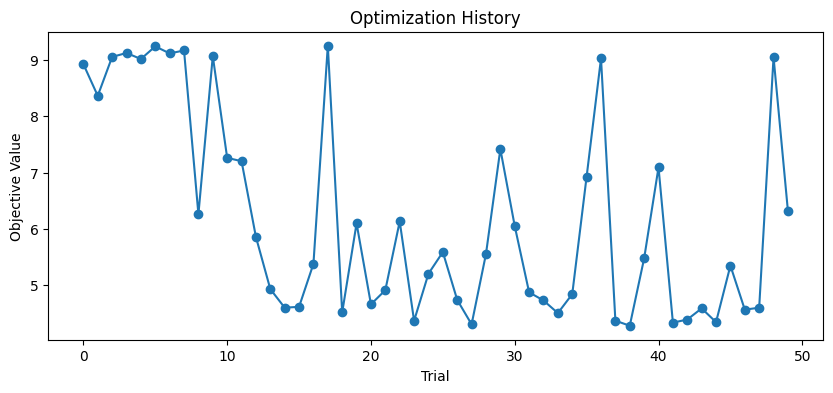

In [ ]:
# ========== 定义可调生成器 ==========
def build_generator_tunable(trial):
    # 超参数搜索空间
    units1 = trial.suggest_int("units1", 64, 256, step=32)
    units2 = trial.suggest_int("units2", 32, 128, step=16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    use_residual = trial.suggest_categorical("use_residual", [True, False])
    
    # 构建模型
    inputs = Input(shape=(120, 3))
    x1 = LSTM(units1, return_sequences=True)(inputs)
    x1 = LayerNormalization()(x1)
    x1 = Dropout(dropout_rate)(x1)
    
    x2 = LSTM(units2, return_sequences=True)(x1)
    x2 = LayerNormalization()(x2)
    x2 = Dropout(dropout_rate)(x2)
    
    # 条件残差连接
    if use_residual and (units1 == units2):
        x = tf.keras.layers.Add()([x1, x2])
    else:
        x = x2
    
    x = TimeDistributed(Dense(32, activation='tanh'))(x)
    outputs = TimeDistributed(Dense(3, activation='tanh'))(x)
    return Model(inputs, outputs)

# ========== 评估指标 ==========
def evaluate_generator(generator, real_data):
    fake_data = generator.predict(real_data, verbose=0)
    
    # 1. 均值差异
    mean_diff = tf.reduce_mean(tf.abs(
        tf.reduce_mean(real_data, axis=[0, 1]) - 
        tf.reduce_mean(fake_data, axis=[0, 1])
    )).numpy()
    
    # 2. 动态时间规整（DTW）距离（需安装 dtw-python）
    try:
        from dtw import dtw
        dtw_dist = np.mean([dtw(real_data[i,:,0], fake_data[i,:,0]).distance
                            for i in range(min(10, real_data.shape[0]))])  # 取前10个样本计算
    except:
        dtw_dist = 0.0
    
    return mean_diff + dtw_dist * 0.1  # 组合指标

# ========== Optuna 目标函数 ==========
def objective(trial):
    # 生成器超参数
    generator = build_generator_tunable(trial)
    
    # 训练超参数
    lr = trial.suggest_float("lr", 5e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 3, 30, step=3)
    
    # 编译生成器（简化训练，实际需结合TimeGAN完整流程）
    generator.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=lr,
            clipnorm=trial.suggest_float("clipnorm", 0.5, 2.0)
        ),
        loss='mse'
    )
    
    # 生成模拟数据（实际使用时替换为真实数据）
    np.random.seed(42)
    real_data = np.random.normal(size=(256, 120, 3)).astype(np.float32)
    
    # 模拟训练（真实训练需用TimeGAN的对抗流程）
    generator.fit(
        real_data, real_data,  # 自编码器式预训练
        batch_size=batch_size,
        epochs=epochs,
        verbose=0
    )
    
    # 评估生成质量
    return evaluate_generator(generator, real_data)

# ========== 运行优化 ==========
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner()
)

study.optimize(objective, n_trials=50, n_jobs=1)  # n_jobs=-1可并行但需处理TensorFlow多进程问题

# ========== 结果分析 ==========
print("Best hyperparameter:")
for key, value in study.best_trial.params.items():
    print(f"{key:>15}: {value}")

print(f"\nBest Score: {study.best_value:.4f}")

# 可视化
# 优化历史图
plt.figure(figsize=(10, 4))
plt.plot([t.value for t in study.trials], 'o-')
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.title("Optimization History")
plt.show()

In [ ]:
# ========== 评估指标 ==========
def evaluate_generator(generator, real_data):
    fake_data = generator.predict(real_data, verbose=0)
    
    # 1. 均值差异
    mean_diff = tf.reduce_mean(tf.abs(
        tf.reduce_mean(real_data, axis=[0, 1]) - 
        tf.reduce_mean(fake_data, axis=[0, 1])
    )).numpy()
    
    # 2. 动态时间规整（DTW）距离（需安装 dtw-python）
    try:
        from dtw import dtw
        dtw_dist = np.mean([dtw(real_data[i,:,0], fake_data[i,:,0]).distance
                            for i in range(min(10, real_data.shape[0]))])  # 取前10个样本计算
    except:
        dtw_dist = 0.0
    
    return mean_diff + dtw_dist * 0.1  # 组合指标

In [ ]:
# ========== Optuna 目标函数 ==========
def objective(trial):
    # 生成器超参数
    generator = build_generator_tunable(trial)
    
    # 训练超参数
    lr = trial.suggest_float("lr", 5e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 3, 30, step=3)
    
    # 编译生成器（简化训练，实际需结合TimeGAN完整流程）
    generator.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=lr,
            clipnorm=trial.suggest_float("clipnorm", 0.5, 2.0)
        ),
        loss='mse'
    )
    
    # 生成模拟数据（实际使用时替换为真实数据）
    np.random.seed(42)
    real_data = np.random.normal(size=(256, 120, 3)).astype(np.float32)
    
    # 模拟训练（真实训练需用TimeGAN的对抗流程）
    generator.fit(
        real_data, real_data,  # 自编码器式预训练
        batch_size=batch_size,
        epochs=epochs,
        verbose=0
    )
    
    # 评估生成质量
    return evaluate_generator(generator, real_data)

# ========== 运行优化 ==========
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner()
)

study.optimize(objective, n_trials=50, n_jobs=1)  # n_jobs=-1可并行但需处理TensorFlow多进程问题

# ========== 结果分析 ==========
print("Best hyperparameter:")
for key, value in study.best_trial.params.items():
    print(f"{key:>15}: {value}")

print(f"\nBest Score: {study.best_value:.4f}")

# 可视化
# 优化历史图
plt.figure(figsize=(10, 4))
plt.plot([t.value for t in study.trials], 'o-')
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.title("Optimization History")
plt.show()

### Optimizing the hyperparameter of Discriminator

In [159]:
def build_discriminator_tunable(trial):
    inputs = Input(shape=(120, 3))
    
    # 超参数搜索空间
    gru_units = trial.suggest_int("gru_units", 32, 256, step=32)
    dense_units = trial.suggest_int("dense_units", 16, 128, step=16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    use_layer_norm = trial.suggest_categorical("use_layer_norm", [True, False])
    
    # 核心架构
    x = GRU(gru_units, return_sequences=False)(inputs)
    if use_layer_norm:
        x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs, outputs)

In [160]:
def objective(trial):
    # 1. 构建模型
    discriminator = build_discriminator_tunable(trial)
    
    # 2. 超参数搜索
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
    # 3. 编译模型
    discriminator.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # 4. 模拟数据（实际使用时替换为真实数据）
    real_data = np.random.normal(size=(1000, 120, 3)).astype(np.float32)
    fake_data = np.random.uniform(-1, 1, size=(1000, 120, 3)).astype(np.float32)
    
    X = np.concatenate([real_data, fake_data])
    y = np.array([1]*1000 + [0]*1000)  # 1=real, 0=fake
    
    # 5. 训练验证拆分
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    
    # 6. 训练（简化版）
    history = discriminator.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=10,
        verbose=0
    )
    
    # 7. 返回验证集准确率（最大化）
    return max(history.history['val_accuracy'])

In [161]:
# 创建Study
study = optuna.create_study(
    direction="maximize",  # 最大化判别准确率
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()  # 自动剪枝低效试验
)

# 运行优化
study.optimize(objective, n_trials=20, n_jobs=1)

# 输出结果
print("最佳超参数:")
for key, value in study.best_trial.params.items():
    print(f"{key:>15}: {value}")

print(f"\n最佳验证准确率: {study.best_value:.4f}")

[I 2025-04-16 19:35:45,023] A new study created in memory with name: no-name-428c1d7e-bcb9-461f-a7f7-cf0e2e700ae8
[I 2025-04-16 19:35:54,005] Trial 0 finished with value: 0.6549999713897705 and parameters: {'gru_units': 96, 'dense_units': 128, 'dropout_rate': 0.39279757672456206, 'use_layer_norm': True, 'lr': 2.0511104188433963e-05, 'batch_size': 64}. Best is trial 0 with value: 0.6549999713897705.
[I 2025-04-16 19:36:08,861] Trial 1 finished with value: 0.49000000953674316 and parameters: {'gru_units': 192, 'dense_units': 16, 'dropout_rate': 0.4879639408647978, 'use_layer_norm': True, 'lr': 2.3102018878452926e-05, 'batch_size': 128}. Best is trial 0 with value: 0.6549999713897705.
[I 2025-04-16 19:36:19,830] Trial 2 finished with value: 0.6449999809265137 and parameters: {'gru_units': 128, 'dense_units': 48, 'dropout_rate': 0.34474115788895177, 'use_layer_norm': False, 'lr': 5.4041038546473305e-05, 'batch_size': 64}. Best is trial 0 with value: 0.6549999713897705.
[I 2025-04-16 19:36:

🎯 最佳超参数:
      gru_units: 192
    dense_units: 48
   dropout_rate: 0.3080272084711243
 use_layer_norm: True
             lr: 0.0008692991511139548
     batch_size: 64

🏆 最佳验证准确率: 1.0000


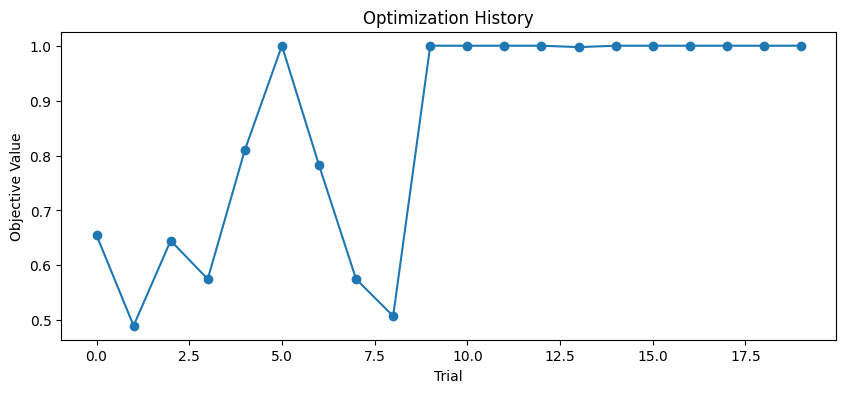

In [162]:
# 优化历史图
plt.figure(figsize=(10, 4))
plt.plot([t.value for t in study.trials], 'o-')
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.title("Optimization History")
plt.show()

### Train Time-Gan Model

In [185]:
# ========== Best Hyperparameters ==========
BEST_PARAMS = {
    "units1": 256,
    "units2": 96,
    "dropout_rate": 0.1246,
    "use_residual": True,
    "learning_rate": 0.0006804,
    "batch_size": 16,
    "epochs": 1, #27
    "clipnorm": 0.8792
}

# ========== Generator with Residual Option ==========
def build_best_generator(params):
    inputs = Input(shape=(120, 3))
    x = LSTM(params["units1"], return_sequences=True)(inputs)
    x = LayerNormalization()(x)
    x = Dropout(params["dropout_rate"])(x)
    x_skip = x

    x = LSTM(params["units2"], return_sequences=True)(x)
    x = LayerNormalization()(x)
    x = Dropout(params["dropout_rate"])(x)

    if params["use_residual"]:
        x_skip_proj = TimeDistributed(Dense(params["units2"]))(x_skip)
        x = Add()([x, x_skip_proj])  # Residual connection

    x = TimeDistributed(Dense(64, activation='tanh'))(x)
    outputs = TimeDistributed(Dense(3, activation='tanh'))(x)
    return Model(inputs, outputs)

# Supervisor
def build_supervisor(units1, units2):
    inputs = Input(shape=(120, 3))
    x = LSTM(units1, return_sequences=True)(inputs)
    x = LayerNormalization()(x)
    x = LSTM(units2, return_sequences=True)(x)
    x = LayerNormalization()(x)
    outputs = TimeDistributed(Dense(3))(x)
    return Model(inputs, outputs)

# Discriminator
def build_discriminator_trial17():
    inputs = Input(shape=(120, 3))
    x = GRU(32, return_sequences=True)(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.1767)(x)
    x = GRU(32, return_sequences=False)(x)
    x = LayerNormalization()(x)
    x = Dropout(0.1767)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

In [186]:
# ========== Build and Compile ==========
generator = build_best_generator(BEST_PARAMS)
supervisor = build_supervisor(BEST_PARAMS["units1"], BEST_PARAMS["units2"])
discriminator = build_discriminator_trial17()

timegan = TimeGAN(generator, discriminator, supervisor)
timegan.compile(
    gen_optimizer=tf.keras.optimizers.Adam(learning_rate=BEST_PARAMS["learning_rate"], clipnorm=BEST_PARAMS["clipnorm"]),
    disc_optimizer=tf.keras.optimizers.Adam(learning_rate=BEST_PARAMS["learning_rate"], clipnorm=BEST_PARAMS["clipnorm"]),
    sup_optimizer=tf.keras.optimizers.Adam(learning_rate=BEST_PARAMS["learning_rate"], clipnorm=BEST_PARAMS["clipnorm"]),
    gen_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    disc_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    sup_loss_fn=tf.keras.losses.MeanSquaredError()
)

In [187]:
# ========== Training Loop ==========
os.makedirs("saved_models", exist_ok=True)
best_total_loss = float("inf")

train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.batch(BEST_PARAMS["batch_size"], drop_remainder=True).shuffle(100)

for epoch in range(1, BEST_PARAMS["epochs"] + 1):
    print(f"\n Epoch {epoch}/{BEST_PARAMS['epochs']}")
    progress_bar = tqdm(train_dataset, desc="Training")

    total_gen_loss = 0.0
    total_sup_loss = 0.0
    total_disc_loss = 0.0
    num_batches = 0

    for batch in progress_bar:
        num_batches += 1

        with tf.GradientTape() as gen_tape, tf.GradientTape() as sup_tape, tf.GradientTape() as disc_tape:
            fake_sequences = generator(batch, training=True)
            padded_input = tf.pad(fake_sequences[:, :-1, :], [[0, 0], [0, 1], [0, 0]])
            pred_next_step = supervisor(padded_input, training=True)
            sup_loss = tf.keras.losses.MeanSquaredError()(fake_sequences[:, 1:, :], pred_next_step[:, :-1, :])

            d_real = discriminator(batch, training=True)
            d_fake = discriminator(fake_sequences, training=True)
            real_labels = tf.ones_like(d_real)
            fake_labels = tf.zeros_like(d_fake)

            d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_real))
            d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, d_fake))
            d_loss_total = 0.5 * (d_loss_real + d_loss_fake)

            g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_fake))
            combined_gen_loss = g_loss + 0.5 * sup_loss

        gen_grads = gen_tape.gradient(combined_gen_loss, generator.trainable_variables)
        disc_grads = disc_tape.gradient(d_loss_total, discriminator.trainable_variables)
        sup_grads = sup_tape.gradient(sup_loss, supervisor.trainable_variables)

        timegan.gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
        timegan.disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
        timegan.sup_optimizer.apply_gradients(zip(sup_grads, supervisor.trainable_variables))

        total_gen_loss += combined_gen_loss.numpy()
        total_sup_loss += sup_loss.numpy()
        total_disc_loss += d_loss_total.numpy()

        progress_bar.set_postfix({
            "G Loss": f"{combined_gen_loss.numpy():.4f}",
            "Sup Loss": f"{sup_loss.numpy():.4f}",
            "D Loss": f"{d_loss_total.numpy():.4f}"
        })

    avg_g_loss = total_gen_loss / num_batches
    avg_sup_loss = total_sup_loss / num_batches
    avg_d_loss = total_disc_loss / num_batches

    print(f"Epoch {epoch} Summary - G Loss: {avg_g_loss:.4f}, Sup Loss: {avg_sup_loss:.4f}, D Loss: {avg_d_loss:.4f}")

    if avg_g_loss + 0.5 * avg_sup_loss < best_total_loss:
        best_total_loss = avg_g_loss + 0.5 * avg_sup_loss
        generator.save("saved_models_1/best_generator.h5")
        supervisor.save("saved_models_1/best_supervisor.h5")
        discriminator.save("saved_models_1/best_discriminator.h5")
        print("Best models saved!")

\n🚀 Epoch 1/1


Training:   0%|          | 12/3449 [00:27<2:11:25,  2.29s/it, G Loss=1.0958, Sup Loss=0.1811, D Loss=0.3255]

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
Training: 100%|██████████| 3449/3449 [2:14:25<00:00,  2.34s/it, G Loss=0.6902, Sup Loss=0.0014, D Loss=0.7126]  


✅ Epoch 1 Summary - G Loss: 0.9419, Sup Loss: 0.0211, D Loss: 0.6795
💾 Best models saved!


In [210]:
# ================== Step 1: 生成数据 ==================
# 生成数据时使用噪声，而非真实数据
batch_size = 32
sequence_length = 120  # 1小时数据
num_features = 3  # 3个传感器

# 生成噪声
noise = np.random.normal(size=(batch_size, sequence_length, num_features))
synthetic_data = generator.predict(noise)

# 逆归一化数据
synthetic_data_denorm = scaler.inverse_transform(
    synthetic_data.reshape(-1, num_features)
).reshape(synthetic_data.shape)

# 注入更平滑的异常
synthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm * np.random.uniform(0.9, 1.1))

print("\n✅ 生成数据示例（含异常）:")
print(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看异常数据

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

✅ 生成数据示例（含异常）:
[0.4604091 0.4604091 0.4604091 0.4604092 0.4604091]


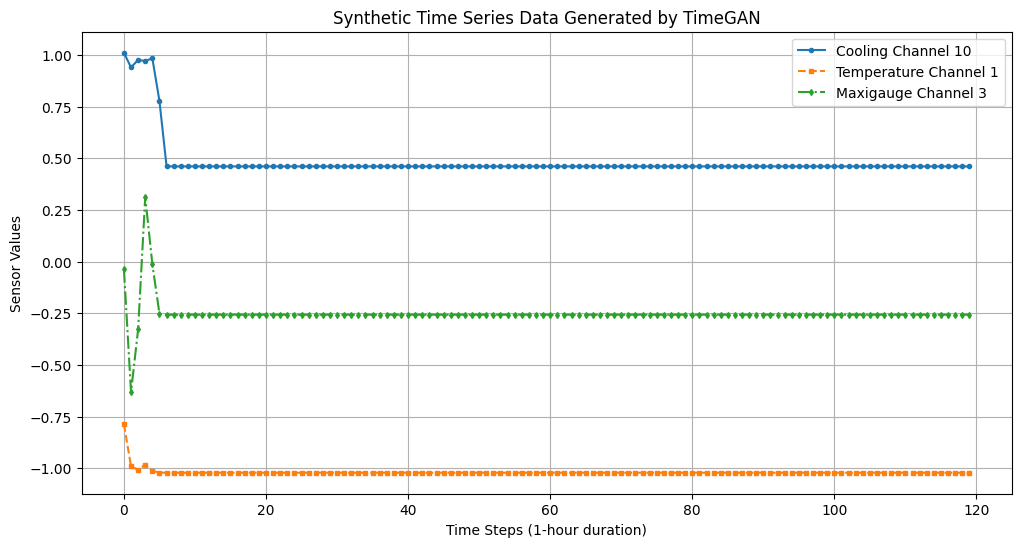

In [211]:
# ================== Step 2: 可视化真实 vs 生成数据 ==================
# 选择一个样本进行可视化 (batch 中的第一个)
sample_idx = 0
sample_data = synthetic_data_with_anomalies[sample_idx]  # Shape: (120, 3)
time_steps = np.arange(sequence_length)  # 时间步

# 绘制 3 个特征的时间序列
plt.figure(figsize=(12, 6))
plt.plot(time_steps, sample_data[:, 0], label="Cooling Channel 10", linestyle='-', marker='o', markersize=3)
plt.plot(time_steps, sample_data[:, 1], label="Temperature Channel 1", linestyle='--', marker='s', markersize=3)
plt.plot(time_steps, sample_data[:, 2], label="Maxigauge Channel 3", linestyle='-.', marker='d', markersize=3)

# 图像美化
plt.xlabel("Time Steps (1-hour duration)")
plt.ylabel("Sensor Values")
plt.title("Synthetic Time Series Data Generated by TimeGAN")
plt.legend()
plt.grid(True)

In [212]:
# 保存可视化结果
plot_filename = "../databases/synthetic_time_series_1.png"
plt.savefig(plot_filename)
plt.show()

print(f"\n✅ 可视化图像已保存: {plot_filename}")

<Figure size 640x480 with 0 Axes>


✅ 可视化图像已保存: ../databases/synthetic_time_series_1.png
